# **Chapter 12: Classification with Support Vector Machines**

>[Chapter 12: Classification with Support Vector Machines](#scrollTo=KNM5oSTvsXEr)

>>[Creating Synthetic Dataset](#scrollTo=g_i9alq2z3rV)

>>[12.1 - 12.2 Separating Hyperplanes and Primal Support Vector Machine](#scrollTo=X8YvN3Ng6CYd)

>>>[12.2.1 Concept of the Margin](#scrollTo=DWrMCWIuFF4g)

>>>[12.2.3 Why We Can Set the Margin to 1](#scrollTo=NMams1XmMh1Y)

>>>[12.2.4 Soft Margin SVM : Geometric View](#scrollTo=0_7dHKVqX2NS)

>>>[12.2.5 Soft Margin SVM : Loss Function View](#scrollTo=gjwp3Th_XqoK)

>>[12.3  Dual Support Vector Machine](#scrollTo=YFATVJ4UKDHo)

>>[12.4 Kernels](#scrollTo=BFkgHeQ3YhZP)

>[A Real Life Case Study Implementation : Healthcare Dataset](#scrollTo=3-9wSJbKqMRt)



This notebook is designed by **Priyanka Roy**, an on-going master's student in Computer Science with special collaboration in AI program for Fall 2025 at the University of Guelph, Ontario, Canada. In this notebook, we will try to cover the basic mathematical concepts for Support Vector Machines (SVM), a popular supervised machine learning algorithm for classification and regression tasks, following the [Mathematics for Machine Learning Book](https://mml-book.github.io/book/mml-book.pdf) (Chapter 12). In this notebook, we will explore the concepts behind support vector machines and later apply them to a practical binary classification problem.

The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space (N is the number of features) that distinctly classifies the data points. **Hyperplanes** are basically decision boundaries that help classify the data points. In binary classification task, the output is binary values, i.e., there are only two possible outcomes. For binary classification, the set of possible values that the label/output can attain is binary, and following the reference book, we denote them by ${+1,−1}$. So, the predicator form is:

</br>

$$f : R^D → \{+1, −1\} \tag{12.1a}$$

</br>

Given a training data set consisting of example–label pairs ${(x_1,y_1),...,(x_n,y_n)}$, we would like to estimate parameters of the model that will give the smallest classification error. The general formula for a hyperplane in an \(n\)-dimensional space is the linear equation:

</br>

$$w_{1}x_{1}+w_{2}x_{2}+\dots +w_{n}x_{n}+b=0$$

</br>

This can also be written in a more compact vector form using the inner product as follows:

$${w}^{T}x + b = 0 \quad \text{or} \quad 〈w, x〉+b = 0 \tag{12.1b}$$

Where,
- $x = (x_{1},x_{2},\dots ,x_{n})$ is a point on the hyperplane,
- $w = (w_{1},w_{2},\dots ,w_{n})$ is the weight vector, and
- $b$ is the bias term

</br>

Our main goal is to find the optimal $w$ and $b$ that maximize the **margin** (distance) between the hyperplane and the closest data points (**support vectors**) from both classes.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs, make_classification
from sklearn.decomposition import PCA

from scipy.optimize import minimize
from scipy.spatial import ConvexHull

%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as ex

from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve, LearningCurveDisplay
from sklearn.metrics import *

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

## **Creating Synthetic Dataset**

To train and test the SVM models and show various concepts from the reference book (mml), here we create a synthetic dataset and display some basic visualizations. For reproducibility, we use the `random_state` parameter of the `make_blobs` function.

In [ ]:
np.random.seed(42)
X, y = make_blobs(n_samples=80, centers=[(-1, 1), (2, -1)], cluster_std=[0.9, 0.9], random_state=42)
y = np.where(y == 0, -1, 1) # here we converted our target labels to 1 and -1 to align with the conventions of the reference book

In this section, we present a scatter plot of the dataset prior to scaling.

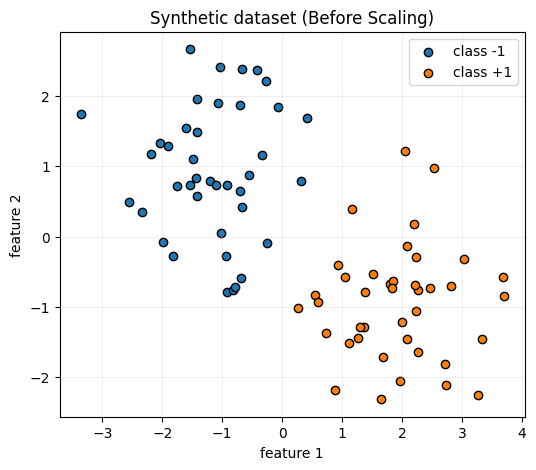

In [ ]:
plt.figure(figsize=(6,5))
plt.scatter(X[y==-1,0], X[y==-1,1], label='class -1', edgecolor='k')
plt.scatter(X[y==1,0], X[y==1,1], label='class +1', edgecolor='k')
plt.legend()
plt.title('Synthetic dataset (Before Scaling)')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.grid(alpha=0.2)
plt.show()

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In this section, we again visualize the dataset after using `StandardScaler` from the `scikit-learn` library. Scaling transforms the data to a limited range which helps the machine learning models to learn well.

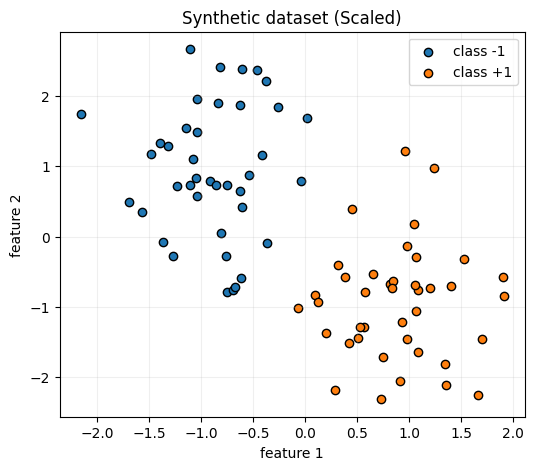

In [ ]:
plt.figure(figsize=(6,5))
plt.scatter(X_scaled[y==-1, 0], X[y==-1,1], label='class -1', edgecolor='k')
plt.scatter(X_scaled[y==1, 0], X[y==1,1], label='class +1', edgecolor='k')
plt.legend()
plt.title('Synthetic dataset (Scaled)')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.grid(alpha=0.2)
plt.show()

 The plot above is similar to the **Figure 12.1** from the [Mathematics for Machine Learning Book](https://mml-book.github.io/book/mml-book.pdf) which illustrates the intuition of data. From this plot, we can make assumptions that a linear classifier can separate the orange dots from the blue ones.

 </br>



## **12.1 - 12.2 Separating Hyperplanes and Primal Support Vector Machine**

To understand the basic workings of SVM, we will begin by defining a utility function called `plot_separator`. This function is intended to visualize the decision boundary and the margins of a linear SVM, based on the wight vector $w$, bias $b$, input features $x$, and the labels $y$.

In [ ]:
def plot_separator(w, b, X, y, title=''):
    # w: weight vector, b: bias scalar
    xx = np.linspace(X[:,0].min()-1, X[:,0].max()+1, 200)
    yy = -(w[0]*xx + b)/w[1]
    margin = 1.0/np.linalg.norm(w)
    yy_up = -(w[0]*xx + b - 1)/w[1]
    yy_down = -(w[0]*xx + b + 1)/w[1]

    plt.figure(figsize=(6,5))
    plt.plot(xx, yy, 'k-', label='decision boundary')
    plt.plot(xx, yy_up, 'k--', alpha=0.7)
    plt.plot(xx, yy_down, 'k--', alpha=0.7)
    plt.scatter(X[y==-1,0], X[y==-1,1], label='-1', edgecolor='k')
    plt.scatter(X[y==1,0], X[y==1,1], label='+1', edgecolor='k')
    plt.title(title + f'  (margin = {2/np.linalg.norm(w):.3f})')
    plt.legend(); plt.grid(alpha=0.2)
    plt.ylim(X[:,1].min()-1, X[:,1].max()+1)
    plt.xlim(X[:,0].min()-1, X[:,0].max()+1)
    plt.show()

###  **12.2.1 Concept of the Margin**

Now, we will look at our `Linear Support Vector Machine (SVM)` from scratch using subgradient descent (SGD). This function is designed for classification tasks. Here, the basic intuition is that, instead of drawing a zero-width line between the classes shown above, we can actually draw a margin of some width up to the nearest points.

</br>

**You may be wondering, what exactly is a "margin"?**

</br>

In a linearly separable dataset, the margin refers to the distance between the separating hyperplane and the nearest examples in the dataset. The nature of the margin (either soft or hard) is controlled by the value of the regularization parameter $C$.

</br>

A **soft margin** allows some misclassifications or data points to fall within the margin boundary. This is achieved by setting $C$ to a finite, moderate value, which allows the model to prioritize a wider margin and better generalization by penalizing errors flexibly. On the other hand, a **hard margin** seeks a decision boundary that perfectly separates the two classes with the widest possible margin, allowing zero misclassifications and no data points within the margin. This is achieved by setting $C$ to an infinitely large value.

</br>


In [ ]:
def train_svm_primal_sgd(X, y, C=1.0, lr=0.01, epochs=2000, batch_size=None, verbose=False):
    n, d = X.shape
    w = np.zeros(d)
    b = 0.0

    if batch_size is None:
        batch_size = n
    for epoch in range(epochs):
        idx = np.random.choice(n, batch_size, replace=False)
        Xb = X[idx]
        yb = y[idx]
        margins = yb * (Xb.dot(w) + b)

        # subgradient of hinge loss
        idx_miss = margins < 1

        # gradient for w: w - C * sum(y_i x_i) for violated points (average)
        grad_w = w.copy() - C * np.mean((yb[idx_miss][:,None] * Xb[idx_miss]), axis=0) if idx_miss.any() else w
        grad_b = -C * np.mean(yb[idx_miss]) if idx_miss.any() else 0.0

        # gradient step
        w = w - lr * grad_w
        b = b - lr * grad_b
        if verbose and epoch % 500 == 0:
            loss = 0.5 * np.dot(w,w) + C * np.mean(np.maximum(0, 1 - y*(X.dot(w)+b)))
            print(f'Epoch {epoch}, loss {loss:.4f}')
    return w, b

Here, we calculated the `hinge loss` as the loss function for our SVM. For a given data point $(x_i,y_i)$ where $y$ 𝞊 {${-1,+1}$}, the hinge loss is defined by the following formula:

$$ ℓ(t) = max (0, 1−t) \tag{12.28}$$ where,
- $t = yf(x) = y(⟨w,x⟩+b)$


We can rewrite it as follows:
$$ℓ_{hinge} = max(0, 1 - y_i(w^tx_i + b)) $$

</br>

It measures the error for a given set of weights and bias, penalizing misclassified points and points that are within the margin.


</br>

---


</br>


One interesting point to notice here is that our above function is by default designed for `soft_margin`. **Why?**
- **Hint:** Look at the value for $C$.

</br>


Epoch 0, loss 20.0580
Epoch 500, loss 28.5821
Epoch 1000, loss 16.8994
Epoch 1500, loss 15.6202
Epoch 2000, loss 35.2830
Epoch 2500, loss 71.1232
Epoch 3000, loss 59.9050
Epoch 3500, loss 70.9443
Epoch 4000, loss 44.3485
Epoch 4500, loss 60.5845
w_hard, b_hard: [ 9.48063601 -4.93139196] -1.4166666666666665


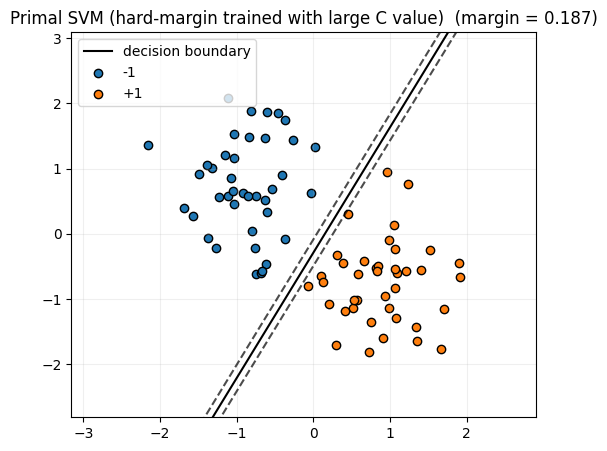

In [ ]:
# changing C value to customize for hard margin
w_hard, b_hard = train_svm_primal_sgd(X_scaled, y, C=1000.0, lr=0.005, epochs=5000, batch_size=40, verbose=True)
print("w_hard, b_hard:", w_hard, b_hard)
plot_separator(w_hard, b_hard, X_scaled, y, title='Primal SVM (hard-margin trained with large C value)')


In SVMs, the line that maximizes this margin is the one we will choose as the optimal model.

### **12.2.3 Why We Can Set the Margin to 1**

SVM objective is scale-invariant. If ($w,b$) is a solution, scaling both by any factor rescales margins.

**Theorem 12.1**. Maximizing the margin $r$, where we consider normalized
weights,

</br>

$$
\max_{w,b,r} \;\underbrace{r}_{\text{margin}}\\
\quad \text{subject to} \quad
\underbrace{y_n(\langle w, x_n\rangle + b) \ge r}_{\text{data fitting}},
\quad \underbrace{\|w\| = 1}_{\text{normalization}},
\quad r > 0
\tag{12.20}
$$

</br>

is equivalent to scaling the data, such that the margin is unity:

</br>

$$
\min_{w,b} \;\underbrace{\frac{1}{2}\|w\|^2}_{\text{margin}}\\
\quad \text{subject to} \quad
\underbrace{y_n(\langle w, x_n\rangle + b) \ge 1}_{\text{data fitting}}
\tag{12.21}
$$

</br>

Note that $r > 0$ because we assumed linear separability, and hence there is no issue to divide by $r$.

Where,
- $w$ is a normal vector to the hyperplane
- $b$ is the intercept
- $r$ is the distance of $x_a$ from the hyperplane
- $x$ is the example
- $y$ is the objective

Margins (min, max): 1.3526535017469286 28.575432318723923
Approx support vector indices: [78]


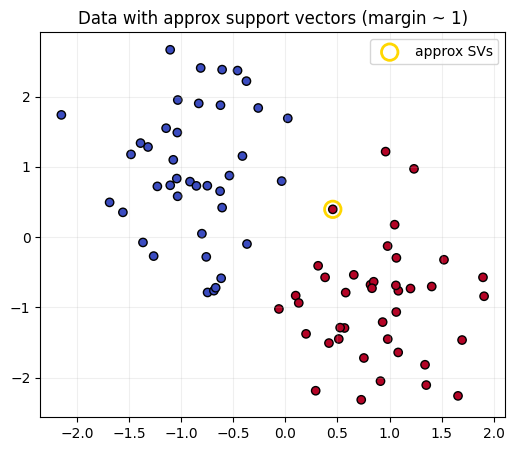

In [ ]:
margins = y * (X_scaled.dot(w_hard) + b_hard)
print("Margins (min, max):", margins.min(), margins.max())

# approximate support vectors
sv_idx = np.where(np.abs(margins - 1) < 0.4)[0]
print("Approx support vector indices:", sv_idx)

plt.figure(figsize=(6,5))
plt.scatter(X_scaled[:,0], X[:,1], c=y, cmap=cm.coolwarm, edgecolor='k')
plt.scatter(X_scaled[sv_idx,0], X[sv_idx,1], s=140, facecolors='none', edgecolors='gold', linewidths=2, label='approx SVs')
plt.title('Data with approx support vectors (margin ~ 1)')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

### **12.2.4 Soft Margin SVM : Geometric View**



When data is not linearly separable, we may wish to allow some examples to fall within the margin region, or even to be on the wrong side of the hyperplane. The model that allows for some classification errors is called the **soft margin SVM**.

In [ ]:
def train_svm_primal_sgd_epochs(X, y, C=1.0, lr=0.01, epochs=2000):
    n, d = X.shape
    w = np.zeros(d)
    b = 0.0
    for epoch in range(epochs):
        idx = np.random.permutation(n)
        for i in idx:
            xi = X[i]; yi = y[i]
            margin = yi * (np.dot(w, xi) + b)
            if margin < 1:
                # subgradient update (hinge)
                grad_w = w - C * yi * xi
                grad_b = -C * yi
            else:
                grad_w = w
                grad_b = 0.0
            w = w - lr * grad_w
            b = b - lr * grad_b
    return w, b

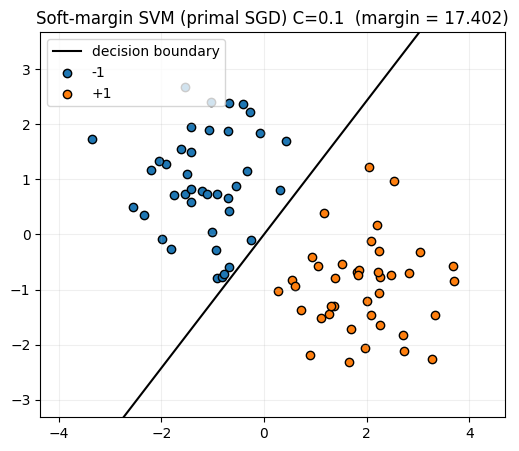

C=0.1, ||w||=0.115, margin=2/||w||=17.402




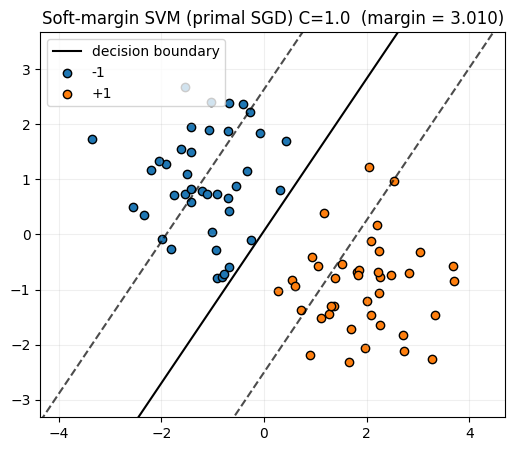

C=1.0, ||w||=0.664, margin=2/||w||=3.010




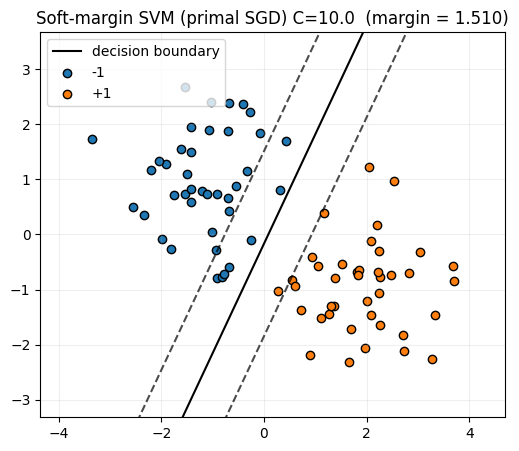

C=10.0, ||w||=1.325, margin=2/||w||=1.510




In [ ]:
for C in [0.1, 1.0, 10.0]:
    w_s, b_s = train_svm_primal_sgd_epochs(X_scaled, y, C=C, lr=0.005, epochs=1500)
    plot_separator(w_s, b_s, X, y, title=f'Soft-margin SVM (primal SGD) C={C}')
    print(f"C={C}, ||w||={np.linalg.norm(w_s):.3f}, margin=2/||w||={2/np.linalg.norm(w_s):.3f}\n\n")

In the first plot the margin is higher, so all data points fall inside the margin region. In the second plot, the margin is medium and some of the data points fall inside the margin region. In the last plot, the margin is less and few data points fall in the margin region. As in the soft margin SVM, these errors are allowed, the hyperplanes are drawn like this.

### **12.2.5 Soft Margin SVM : Loss Function View**

In [ ]:
# scale w and b and show margin scaling
for t in [0.5, 1.0, 2.0]:
    w_t, b_t = t*w_hard, t*b_hard
    margins_t = y*(X_scaled.dot(w_t)+b_t)
    print(f"scale {t}: min margin = {margins_t.min():.3f}, geometric margin = {2/np.linalg.norm(w_t):.3f}")

scale 0.5: min margin = 0.676, geometric margin = 0.374
scale 1.0: min margin = 1.353, geometric margin = 0.187
scale 2.0: min margin = 2.705, geometric margin = 0.094


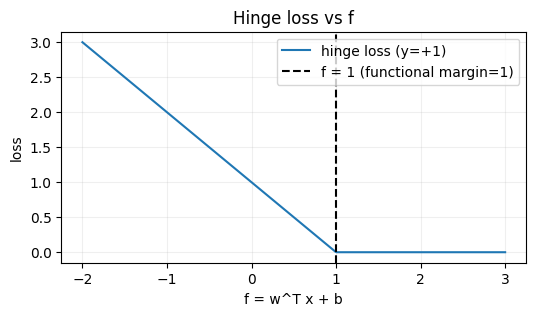

In [ ]:
fs = np.linspace(-2, 3, 400)
hinge = np.maximum(0, 1 - fs)
plt.figure(figsize=(6,3))
plt.plot(fs, hinge, label='hinge loss (y=+1)')
plt.axvline(1, color='k', linestyle='--', label='f = 1 (functional margin=1)')
plt.xlabel('f = w^T x + b')
plt.ylabel('loss')
plt.legend()
plt.title('Hinge loss vs f')
plt.grid(alpha=0.2)
plt.show()

Here, $fs$ denotes model scores ($f = w^T x + b$), an array of 400 evenly spaced values between $-2$ and $3$. Hinge loss can be interpreted as a method that prevents any examples from falling within the margin. To learn more about hinge loss, you can explore this link: [Wikipedia](https://en.wikipedia.org/wiki/Hinge_loss).

Now that we have covered so much about Soft-Margin SVMs, let us unfold the concept of `Soft-margin SVM objective landscape`. It is a blend of both the geometric view and the loss function view.

</br>

---

</br>

Do you remember what soft margins actually do? The objective function that a Soft Margin SVM seeks to minimize is as follows:

</br>

$$\text{Objective}(\mathbf{w}, b) = \min_{\mathbf{w}, b} \underbrace{\frac{1}{2}||\mathbf{w}||^2}_{\text{regularization term}} + \underbrace{C \sum_{n=1}^{N} \max\{0, 1 - y_n (\langle \mathbf{w}, \mathbf{x}_n \rangle + b)\}}_{\text{hinge-loss term}} \tag{12.31}$$

</br>

Here, the first term represents the `regularization term`, while the last term refers to the `Hinge-loss term`. By applying this, we seek to minimize the total loss, while regularizing the objective with $ℓ2$-regularization.

</br>


- **NB:** check [Mathematics for Machine Learning](https://mml-book.github.io/book/mml-book.pdf) book **Section 8.2.3** for more information on regularization.


</br>


</br>

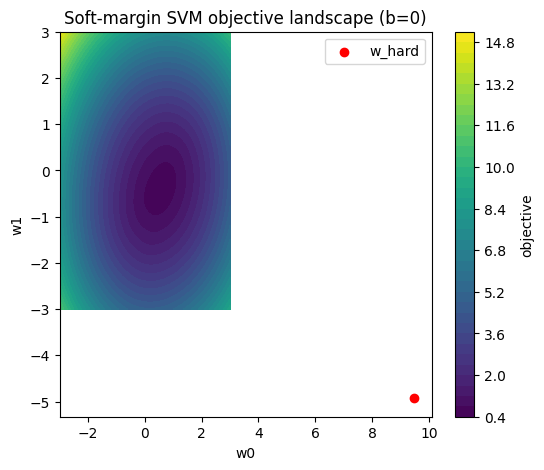

In [ ]:
ws = np.linspace(-3,3,80)
W0, W1 = np.meshgrid(ws, ws)
obj = np.zeros_like(W0)
C=1.0
b0 = 0.0
for i in range(W0.shape[0]):
    for j in range(W0.shape[1]):
        w_try = np.array([W0[i,j], W1[i,j]])
        obj[i,j] = 0.5*np.dot(w_try,w_try) + C * np.mean(np.maximum(0, 1 - y*(X_scaled.dot(w_try) + b0)))

plt.figure(figsize=(6,5))
cs = plt.contourf(W0, W1, obj, levels=40)
plt.colorbar(cs, label='objective')
plt.scatter([w_hard[0]],[w_hard[1]], color='red', label='w_hard')
plt.title('Soft-margin SVM objective landscape (b=0)'); plt.xlabel('w0'); plt.ylabel('w1'); plt.legend(); plt.show()

This above plot visualizes our Soft-margin SVM model's loss landscape, where the minimum (the dark purple center) is the optimal solution for the weight vector `w` that the SVM algorithm seeks to find. The red marker shows the location of a pre-calculated, poorly performing `'hard-margin'` weight vector.

</br>


---

</br>


Can you now explain why we chose **Hinge-loss** when implementing SVM and why it is the most suitable loss function for SVM?

- Hint: In binary classification, the primary goal of SVM is to identify the optimal hyperplane that separates data points into two classes by maximizing the margin. Can you relate this to `hinge loss`?

## **12.3  Dual Support Vector Machine**

Do you remember the concept of `Convex Duality` from **Section 7.2**? SVM supports this duality, which provides an additional advantage of applying kernels.

Confused? Don't worry. Let us break it down together. We will start with the fundamentals. Every optimization problem can be approached in two distinct ways:

1.   Primal Formulation
2.   Dual Formulation

So far, we have explored various concepts in the primal formulation. However, if the primal optimization does not yield any solution, we turn to the **Dual Optimization Formulation**.



The convex hull of a set of points is the smallest convex set that contains all the points. For two linearly separable classes (A and B), the optimal hyperplane lies between the convex hull of Class A and the convex hull of Class B. For convext duality optimization, we use the **Lagrange Multipliers** given by:

</br>

$$
\mathcal{L}(\mathbf{w}, b, \xi, \alpha, \gamma) = \frac{1}{2}||\mathbf{w}||^2 + C \sum_{n=1}^{N} \xi_n - \underbrace{\sum_{n=1}^{N} \alpha_n \left(y_n (\langle \mathbf{w}, \mathbf{x}_n \rangle + b) - 1 + \xi_n \right)}_{\text{Constraint}} - \underbrace{\sum_{n=1}^{N} \gamma_n \xi_n}_{\text{Constraint}} \tag{12.34}
$$

$$
\text{subject to: } \quad \alpha_n \ge 0, \quad \gamma_n \ge 0, \quad \xi_n \ge 0
$$

</br>

This method is required to transform our constrained optimization problem into unconstrained optimization problem. We calculate the optimal values for `w`, `b`, and ${α_n}$ and rewrite our optimal hyperplane, defined entirely by the support vectors and can separate the data points effectively, even in high-dimensional feature spaces:
$$ 〈w,x〉 + b = 0 $$

</br>

The entire purpose of solving the above Lagrangian equation is to find the smallest set of points (the support vectors) that form the convex hull boundaries necessary to define the widest possible gap between the two classes.

The cells below implement the Dual Formulation of the Soft Margin Linear SVM using a Quadratic Programming (QP) solver. The code returns the vector of optimal Lagrange multipliers ${α_n}$, $w$, and $b$, and identifies the convex hull boundary points. Additionally, some visualizations are included to illustrate these concepts more clearly.

In [ ]:
def solve_dual_linear(X, y, C=1.0):
    n = X.shape[0]
    Y = np.outer(y, y)
    K = X.dot(X.T)
    Q = Y * K

    # objective for minimize: 0.5 a^T Q a - 1^T a
    def obj(a): return 0.5 * a.dot(Q).dot(a) - np.sum(a)
    # gradient
    def obj_grad(a): return Q.dot(a) - np.ones_like(a)
    # equality constraint: sum a_i y_i = 0
    cons = ({'type':'eq', 'fun': lambda a: np.dot(a, y), 'jac': lambda a: y})
    bounds = [(0, C)] * n
    a0 = np.zeros(n)
    res = minimize(obj, a0, jac=obj_grad, bounds=bounds, constraints=cons, method='SLSQP', options={'maxiter':1000})
    a = res.x
    # compute w
    w = np.sum((a * y)[:,None] * X, axis=0)
    # compute b using support vectors (0 < a_i < C)
    sv = np.where((a > 1e-5) & (a < C - 1e-5))[0]
    if len(sv) > 0:
        b_vals = [y[i] - np.dot(w, X[i]) for i in sv]
        b = np.mean(b_vals)
    else:
        b = 0.0
    return a, w, b, res

Dual solve success: True ||w_dual - w_primal||: 1.1918352247533874
Number of support vectors (dual): 8


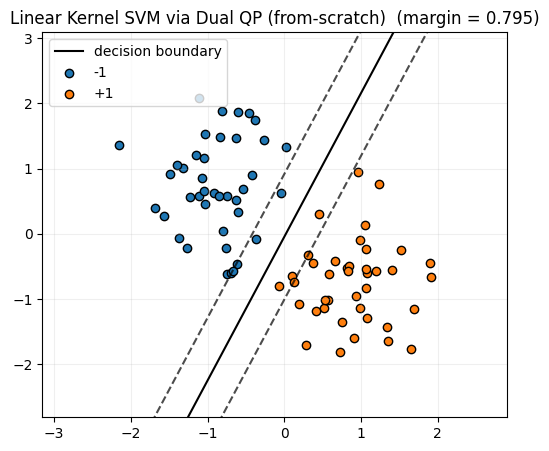

In [ ]:
a_lin, w_dual, b_dual, res = solve_dual_linear(X_scaled, y, C=1.0)
print("Dual solve success:", res.success, "||w_dual - w_primal||:", np.linalg.norm(w_dual - w_s))
print("Number of support vectors (dual):", np.sum(a_lin > 1e-5))
plot_separator(w_dual, b_dual, X_scaled, y, title='Linear Kernel SVM via Dual QP (from-scratch)')

From the plot, we observe that the optimal hyperplane is situated between the convex hull boundaries of two distinct classes.

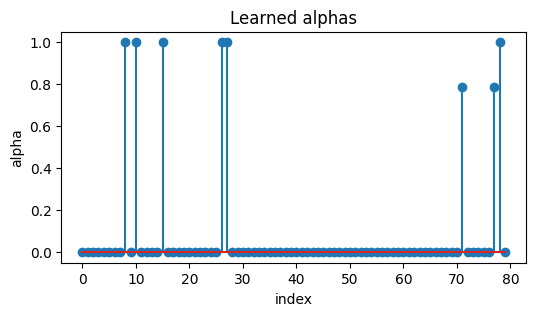

In [ ]:
# alpha distribution
plt.figure(figsize=(6,3))
plt.stem(a_lin)
plt.title('Learned alphas')
plt.xlabel('index')
plt.ylabel('alpha')
plt.show()

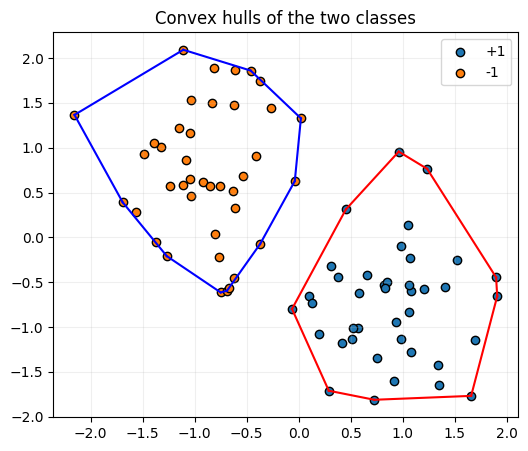

In [ ]:
pts_pos = X_scaled[y==1]
pts_neg = X_scaled[y==-1]
hpos = ConvexHull(pts_pos)
hneg = ConvexHull(pts_neg)

plt.figure(figsize=(6,5))
plt.scatter(pts_pos[:,0], pts_pos[:,1], label='+1', edgecolor='k')
plt.scatter(pts_neg[:,0], pts_neg[:,1], label='-1', edgecolor='k')

for simplex in hpos.simplices:
    plt.plot(pts_pos[simplex,0], pts_pos[simplex,1], 'r-')
for simplex in hneg.simplices:
    plt.plot(pts_neg[simplex,0], pts_neg[simplex,1], 'b-')

plt.title('Convex hulls of the two classes')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

In [ ]:
# Compute closest points between hull vertices (simple approximate)
def closest_pair_between_hulls(h1, pts1, h2, pts2):
    best = (None, None, 1e9)
    for i in h1.vertices:
        for j in h2.vertices:
            d = np.linalg.norm(pts1[i]-pts2[j])
            if d < best[2]:
                best = (i, j, d)
    return best

i, j, dmin = closest_pair_between_hulls(hpos, X_scaled[y==1], hneg, X[y==-1])
print("Approx closest hull vertex indices (pos, neg) and distance:", i, j, dmin)

Approx closest hull vertex indices (pos, neg) and distance: 39 4 0.5027061392737224


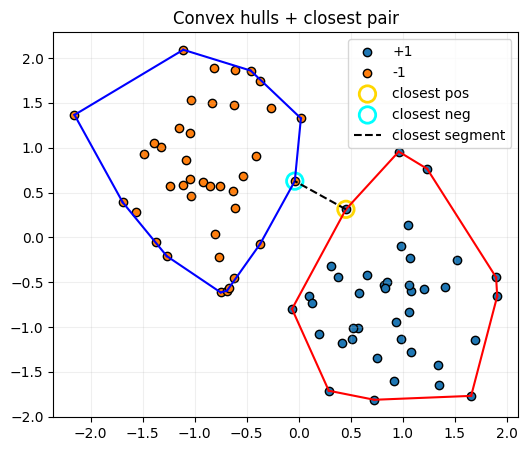

In [ ]:
# Plot hulls and mark the closest pair
plt.figure(figsize=(6,5))
pts_pos = X_scaled[y==1]
pts_neg = X_scaled[y==-1]
plt.scatter(pts_pos[:,0], pts_pos[:,1], label='+1', edgecolor='k')
plt.scatter(pts_neg[:,0], pts_neg[:,1], label='-1', edgecolor='k')

for s in hpos.simplices:
  plt.plot(pts_pos[s,0], pts_pos[s,1], 'r-')

for s in hneg.simplices:
  plt.plot(pts_neg[s,0], pts_neg[s,1], 'b-')

p_closest = pts_pos[i]; n_closest = pts_neg[j]
plt.scatter([p_closest[0]],[p_closest[1]], s=140, facecolors='none', edgecolors='gold', linewidths=2, label='closest pos')
plt.scatter([n_closest[0]],[n_closest[1]], s=140, facecolors='none', edgecolors='cyan', linewidths=2, label='closest neg')
plt.plot([p_closest[0], n_closest[0]],[p_closest[1], n_closest[1]], 'k--', label='closest segment')
plt.title('Convex hulls + closest pair')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

In this implementation, we visualize the convex hulls of two classes in our dataset, labeled as $-1$ and $+1$. The process involves separating the data points based on their class labels (positive and negative) and then computing the smallest convex polygon that encloses all points within each class. We plot these convex hull boundaries alongside the original data points. Lastly, we present a plot that highlights the closest pair of points between the two convex hulls, similar to **Figure 12.9** in the textbook.


</br>

Can you identify the support vectors from the above image?

- **Hint:** What are the data points on the boundary of their respective convex hulls that define the margin of separation?

</br>


## **12.4 Kernels**

Now, do you remember the concept of `Hilbert space` from **Section 3.7**? A Hilbert space is a real or complex inner product space that is also a complete metric space with respect to the metric induced by the inner product [[Wikipedia]](https://en.wikipedia.org/wiki/Hilbert_space). In brief, any complete inner product space is a Hilbert space.

 The generalization from an inner product to a kernel function:
 $$ k(x_i,x_j) = ⟨ϕ(x_i),ϕ(x_j)⟩_𝐻 \tag{12.52}$$

is known as the kernel trick. And here, SVM becomes extremely powerful as it can solve non-linear high dimensional problems using the kernels.

There are four kernels that are frequently used. They are:

1. **Linear Kernel:** It is used when the data is linearly separable.
2. **Polynomial Kernel:** It allows for more complex decision boundaries by adding polynomial features to the data.
3. **Radial Basis Function (RBF) or Gaussian Kernel:** It can handle very complex and non-linear relationships.
4. **Sigmoid Kernel:** it can be used to model relationships similar to neural networks.

We have covered the first three kernels as discussed in the reference book.

In [ ]:
def solve_dual_kernel(X, y, kernel_func, kernel_kwargs={}, C=1.0):
    n = X.shape[0]
    K = kernel_func(X, X, **kernel_kwargs)
    Q = np.outer(y, y) * K
    def obj(a):
      return 0.5 * a.dot(Q).dot(a) - np.sum(a)
    def obj_grad(a):
      return Q.dot(a) - np.ones_like(a)
    cons = ({'type':'eq', 'fun': lambda a: np.dot(a, y), 'jac': lambda a: y})
    bounds = [(0, C)] * n
    a0 = np.zeros(n)
    res = minimize(obj, a0, jac=obj_grad, bounds=bounds, constraints=cons, method='SLSQP', options={'maxiter':1500})
    a = res.x
    sv = np.where(a > 1e-5)[0]
    return a, sv, res

In [ ]:
def rbf_kernel(X1, X2, gamma=0.5):
    # efficient squared euclidean distance
    X1_sq = np.sum(X1**2, axis=1)[:,None]
    X2_sq = np.sum(X2**2, axis=1)[None,:]
    K = X1_sq + X2_sq - 2 * X1.dot(X2.T)
    return np.exp(-gamma * K)

def poly_kernel(X1, X2, degree=3, c=1.0):
    return (X1.dot(X2.T) + c) ** degree

a_rbf, sv_rbf, rbf_res = solve_dual_kernel(X_scaled, y, rbf_kernel, {'gamma':0.7}, C=1.0)
a_poly2, sv_poly2, poly2_res = solve_dual_kernel(X_scaled, y, poly_kernel, {'degree':2, 'c':1.0}, C=1.0)
a_poly3, sv_poly3, poly3_res = solve_dual_kernel(X_scaled, y, poly_kernel, {'degree':3, 'c':1.0}, C=1.0)

print("RBF success:", rbf_res.success, "SV count:", len(sv_rbf))
print("Poly2 SVs:", len(sv_poly2), "Poly3 SVs:", len(sv_poly3))

RBF success: True SV count: 16
Poly2 SVs: 7 Poly3 SVs: 6



</br>

In the above cell, we define two kernels, RBF and Polynomial, and find the Lagrange multipliers $α$ that satisfy the kernel constraints. In addition, the support vectors are counted for each kernel.

</br>


In [ ]:
def kernel_decision(X_train, y_train, a, kernel_func, kernel_kwargs, X_test):
    K = kernel_func(X_test, X_train, **kernel_kwargs)
    return (K * (a * y_train)[None,:]).sum(axis=1)

In [ ]:
def plot_region_ax(ax, grid_vals, Zmat, X, y, sv_idx=None, title=''):
    ax.contourf(grid_vals[0], grid_vals[1], Zmat, alpha=0.3)
    ax.scatter(X[y==-1,0], X[y==-1,1], label='-1', edgecolor='k')
    ax.scatter(X[y==1,0], X[y==1,1], label='+1', edgecolor='k')
    if sv_idx is not None and len(sv_idx)>0:
        ax.scatter(X[sv_idx,0], X[sv_idx,1], facecolors='none', edgecolors='gold', s=120, linewidths=1.5, label='SVs')
    ax.set_title(title)
    ax.set_xlabel('First feature'); ax.set_ylabel('Second feature')

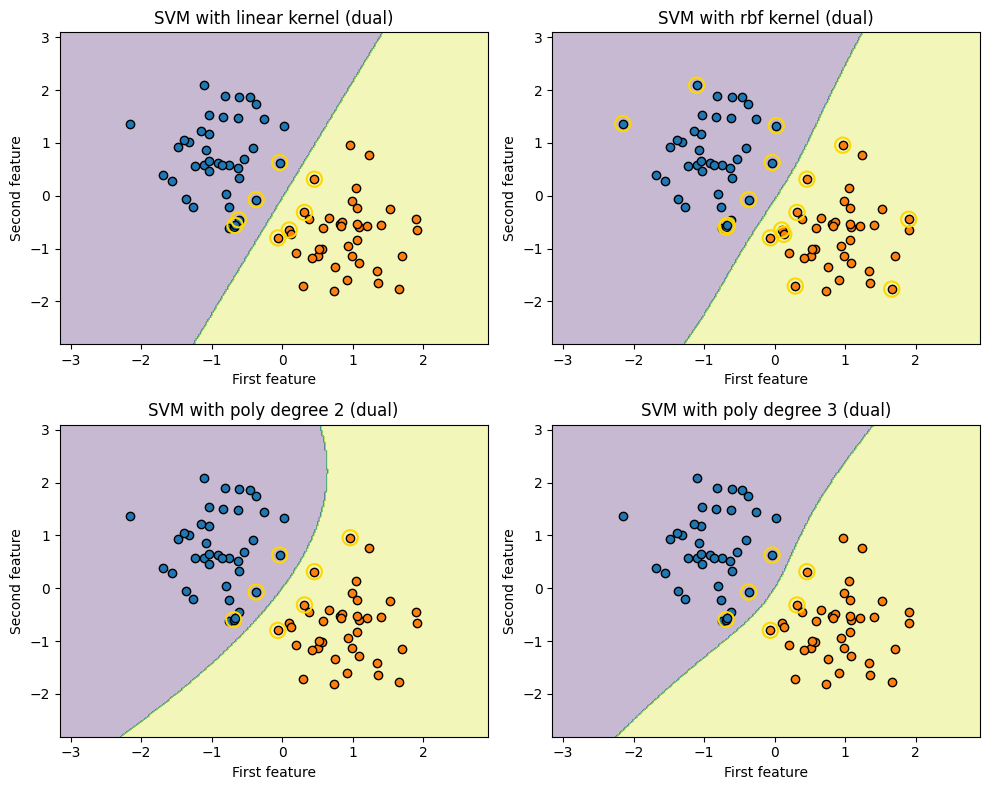

In [ ]:
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2,2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])

xx = np.linspace(X_scaled[:,0].min()-1, X_scaled[:,0].max()+1, 300)
yy = np.linspace(X_scaled[:,1].min()-1, X_scaled[:,1].max()+1, 300)
XX, YY = np.meshgrid(xx, yy); grid = np.c_[XX.ravel(), YY.ravel()]

# Linear using w_dual,b_dual
Z_lin = np.sign(grid.dot(w_dual) + b_dual).reshape(XX.shape)
plot_region_ax(ax1, (XX,YY), Z_lin, X_scaled, y, sv_idx=np.where(a_lin>1e-5)[0], title='SVM with linear kernel (dual)')

# RBF
vals_rbf = kernel_decision(X_scaled, y, a_rbf, rbf_kernel, {'gamma':0.7}, grid)
Z_rbf = np.sign(vals_rbf).reshape(XX.shape)
plot_region_ax(ax2, (XX,YY), Z_rbf, X_scaled, y, sv_idx=sv_rbf, title='SVM with rbf kernel (dual)')

# Polynomial degree2
vals_p2 = kernel_decision(X_scaled, y, a_poly2, poly_kernel, {'degree':2,'c':1.0}, grid)
Z_p2 = np.sign(vals_p2).reshape(XX.shape)
plot_region_ax(ax3, (XX,YY), Z_p2, X_scaled, y, sv_idx=sv_poly2, title='SVM with poly degree 2 (dual)')

# Polynomial degree3
vals_p3 = kernel_decision(X_scaled, y, a_poly3, poly_kernel, {'degree':3,'c':1.0}, grid)
Z_p3 = np.sign(vals_p3).reshape(XX.shape)
plot_region_ax(ax4, (XX,YY), Z_p3, X_scaled, y, sv_idx=sv_poly3, title='SVM with poly degree 3 (dual)')

plt.tight_layout()
plt.show()

In the above cell, we plot the kernel decision boundaries for different SVM kernels. The classes are displayed in different colored regions, and the hyperplane divides the regions. The support vectors are indicated with a golden circle.

From these plots, we can confirm that SVM with kernels can solve non-linear high-dimensional problems efficiently.

# **A Real Life Case Study Implementation : Healthcare Dataset**

Now, we will look into a real-life case study to apply SVM for a binary classification task. But for keeping the notebook simple, we will be using the Scikit-learn library. It is an open-source machine learning library for the Python programming language. We will import `sklearn.svm.SVC`, which is a class in the scikit-learn library that implements **Support Vector Classification (SVC)**, a type of **Support Vector Machine (SVM)** algorithm used for classification tasks.

In [ ]:
dataset= pd.read_csv('https://raw.githubusercontent.com/roypriyanka7/Computational-Thinking-for-AI/refs/heads/main/diabetes.csv')
dataset.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
dataset.shape

(768, 9)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. It is publicly available in [Kaggle](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database). There are 768 data instances and 8 features along with a binary target column `'Outcome'`.

In [ ]:
dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
null_values = dataset.isnull().sum()
print('\nMissing values per column:\n', null_values)


Missing values per column:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [ ]:
print(f"Total number of duplicate rows found: {dataset.duplicated().sum()}")

Total number of duplicate rows found: 0


In [ ]:
target = "Outcome"

dataset[target].value_counts()

,count
Outcome,
0,500
1,268


We examined the dataset for null values, duplicates, and missing entries, and confirmed that none of these issues were present. Next, we analyzed the class distribution of the target variable and found that the dataset contains 500 non-diabetic samples (target = 0) and 268 diabetic samples (target = 1).

In [ ]:
fig = ex.pie(dataset,names=target)
fig.update_layout(title='Proportion Of Diabetes and Not-Diabetes Samples')
fig.show()


>  ${\color{teal}{⚠ \space \textbf{Warning}: \space The \space cell \space below \space needs \space at \space least \space 15 \space seconds \space to \space generate \space all \space the \space plots \space But \space it \space should \space definitely \space run  \space within \space 30 \space seconds.}}$





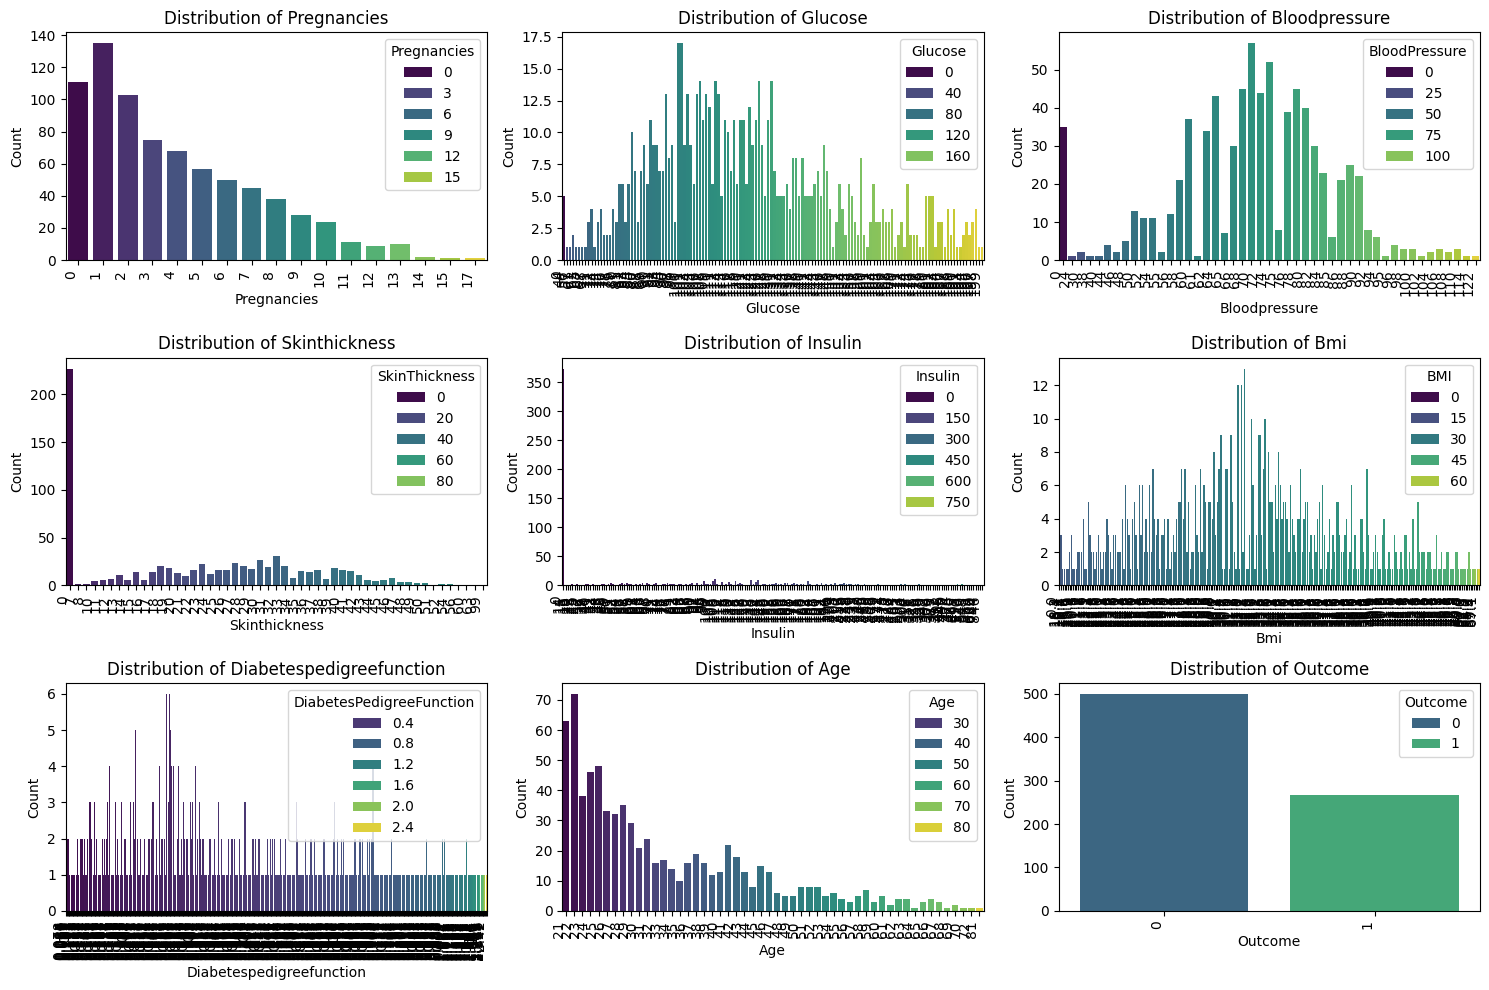

In [ ]:
"""Warning: This cell needs at least 15 sec to generate all the plots.
                                       But it should definitely run within a 30 seconds."""

bar_plot_cols = dataset.columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(bar_plot_cols):
    plt.subplot(3, 3, i + 1)
    sns.countplot(data=dataset, x=col, hue= col, palette='viridis')
    plt.title(f'Distribution of {col.replace("_", " ").title()}')
    plt.xlabel(col.replace("_", " ").title())
    plt.ylabel('Count')
    plt.xticks(rotation=90, ha='right')

plt.tight_layout()
plt.show()

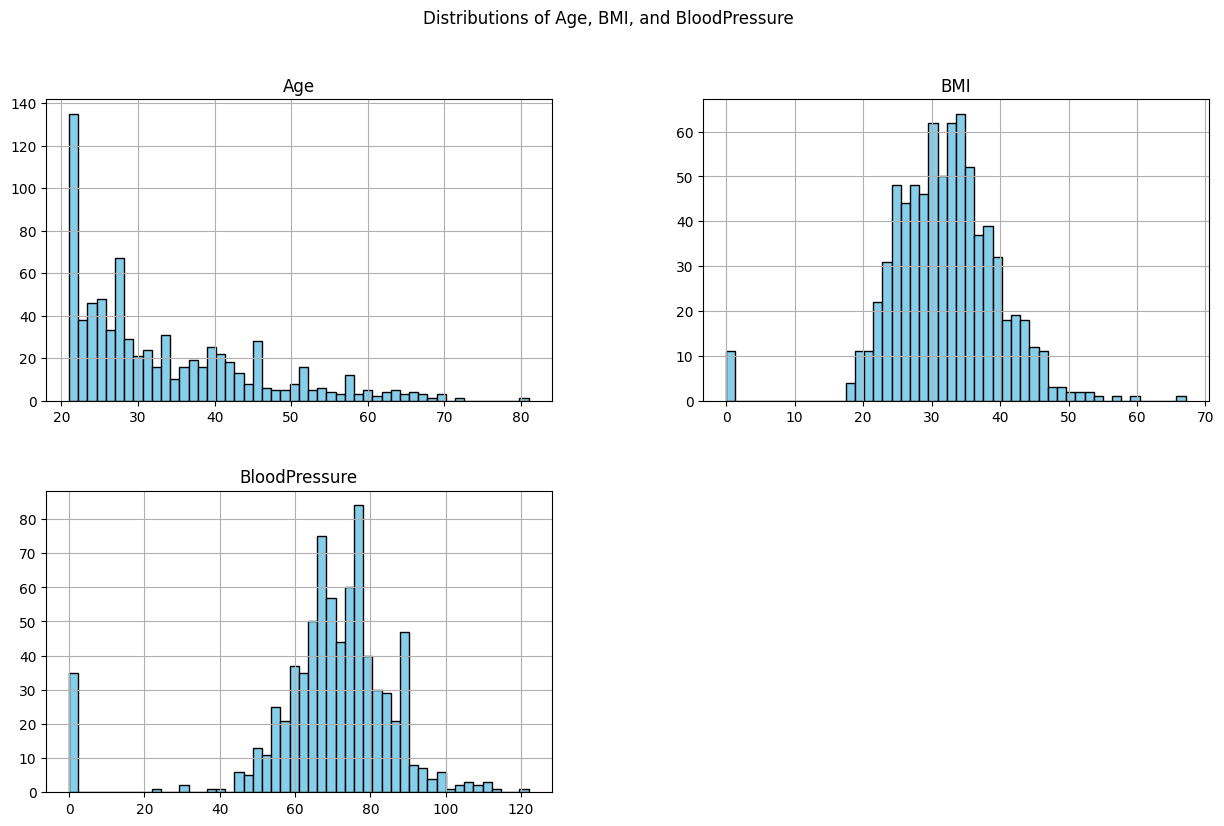

In [ ]:
histogram_cols = ['Age', 'BMI', 'BloodPressure']

dataset[histogram_cols].hist(bins=50, color='skyblue', edgecolor='black', figsize=(15, 9))
plt.suptitle("Distributions of Age, BMI, and BloodPressure")
plt.show()

- Here, we see from the hist plots that the distribution for `BMI` and `Blood Pressure` is normal, while that for `Age` is skewed.

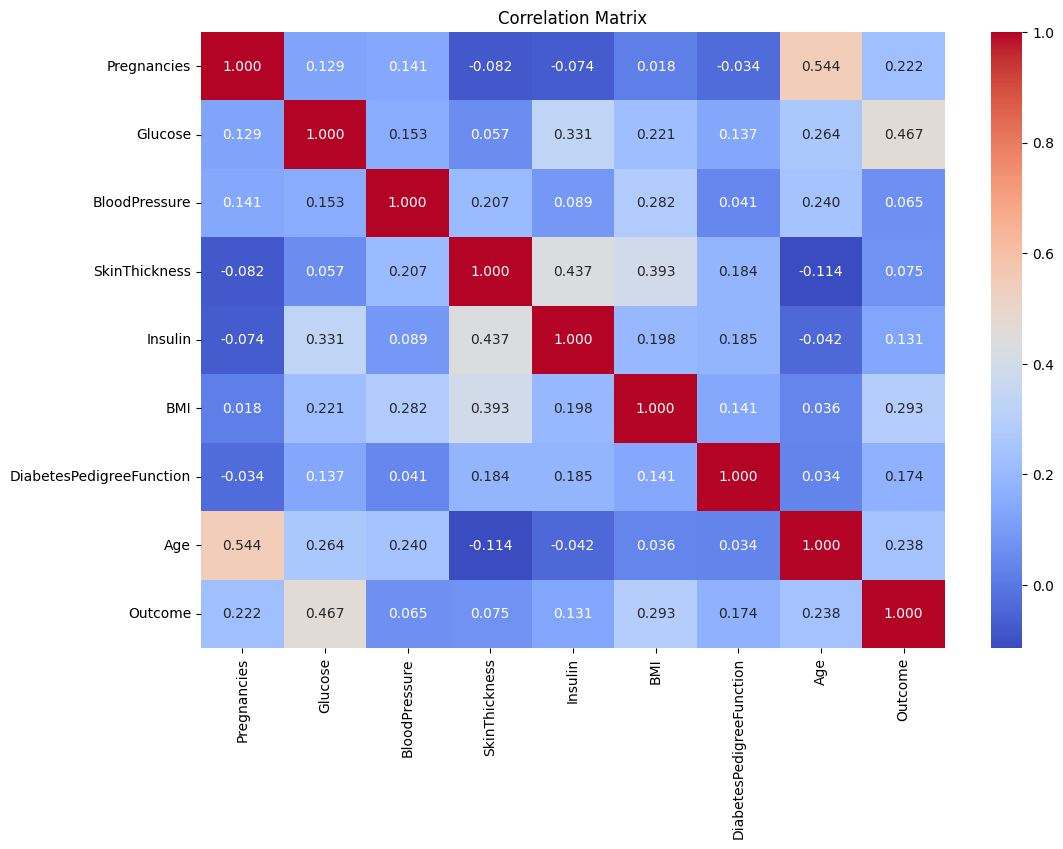

In [ ]:
plt.figure(figsize=(12,8))

corr = dataset.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".3f")
plt.title("Correlation Matrix")
plt.show()

- From the heatmap, we observe that `Glucose`, `BMI`, `Age`, and `Pregnancies` show relatively strong correlations with the target variable, indicating that these features have a notable influence on diabetes prediction.

In [ ]:
X = dataset.drop(columns=[target])
y = dataset[target]

X.shape, y.shape

((768, 8), (768,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)

Training set: (614, 8)
Testing set: (154, 8)


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

We split our dataset into training and testing sets using the `train_test_split` function from the `sklearn.model_selection`. The test size is set to 20% of the dataset. Then we applied standardization to the features using the `StandardScaler` from the `sklearn.preprocessing`.
- Note that we applied standardization after the train-test split to avoid data leakage.

In [ ]:
def evaluate_and_visualize_model(model, X_test, y_test, X_train=None, y_train=None,
                                train_sizes=None, cv=5, figsize=(8, 6)):

    # Generate predictions
    y_pred = model.predict(X_test)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Calculate accuracy and classification report
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Display metrics
    print(f"Accuracy: {accuracy:.3f}")
    print(report)

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

    print('\n\n')

    if X_train is not None and y_train is not None and train_sizes is not None:
        LearningCurveDisplay.from_estimator(
            model,
            X_train,
            y_train,
            train_sizes=train_sizes,
            cv=skf
        )
        plt.show()
    return

Remember our **soft-margin SVM** and **hard-margin SVM**? We will now apply these concepts and define two different instances of SVM - one with soft margins and the other with hard margins. And then we will compare their performance using standard performance metrics offered by `sklearn`.

In [ ]:
soft_margin_svm = SVC(kernel='rbf', probability=True, C=1.0)
soft_margin_svm.fit(X_train_scaled, y_train)

SVC(probability=True)

Accuracy: 0.734
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        99
           1       0.65      0.56      0.60        55

    accuracy                           0.73       154
   macro avg       0.71      0.70      0.70       154
weighted avg       0.73      0.73      0.73       154



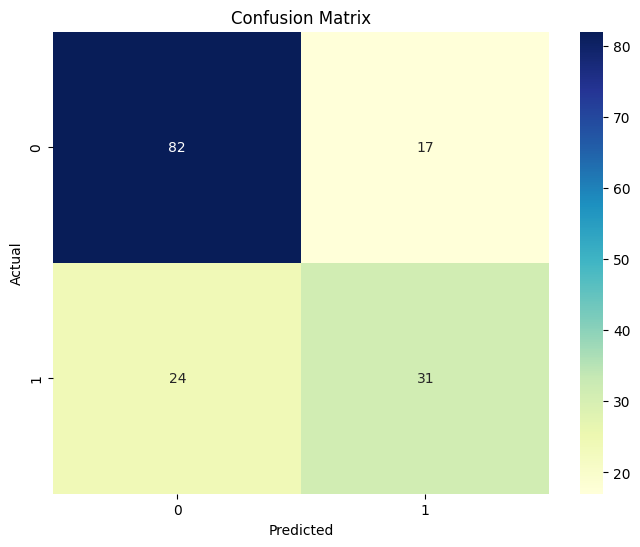

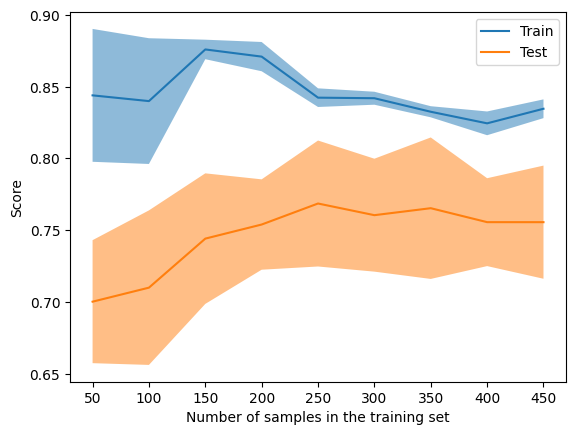

In [ ]:
evaluate_and_visualize_model(
    model=soft_margin_svm,
    X_test=X_test_scaled,
    y_test=y_test,
    X_train=X_train_scaled,
    y_train=y_train,
    train_sizes=[50, 100, 150, 200, 250, 300, 350, 400, 450],
    cv=5
)

In [ ]:
hard_margin_svm = SVC(kernel='linear', probability=True, C=1.0)
hard_margin_svm.fit(X_train_scaled, y_train)

SVC(kernel='linear', probability=True)

Accuracy: 0.760
              precision    recall  f1-score   support

           0       0.81      0.82      0.81        99
           1       0.67      0.65      0.66        55

    accuracy                           0.76       154
   macro avg       0.74      0.74      0.74       154
weighted avg       0.76      0.76      0.76       154



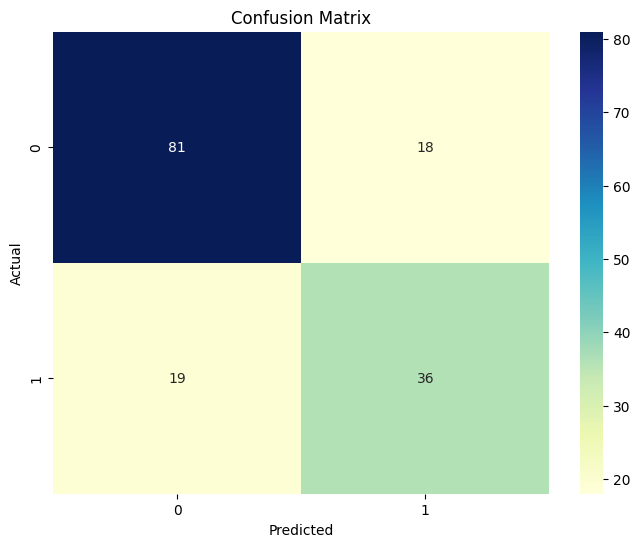

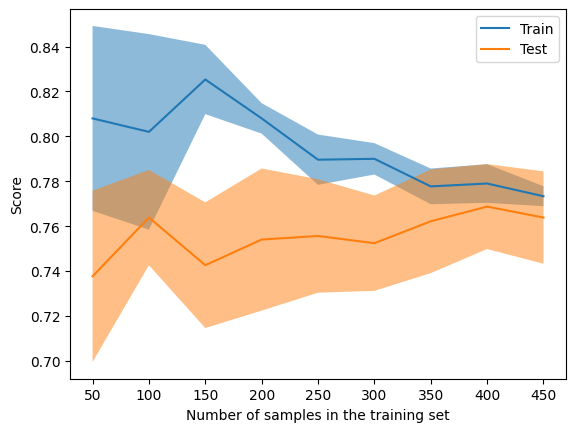

In [ ]:
evaluate_and_visualize_model(
    model=hard_margin_svm,
    X_test=X_test_scaled,
    y_test=y_test,
    X_train=X_train_scaled,
    y_train=y_train,
    train_sizes=[50, 100, 150, 200, 250, 300, 350, 400, 450],
    cv=5
)

We evaluated the performance of both SVM models and visualized their learning behavior using a learning curve that plots train and test accuracy across increasing training sizes. The soft-margin SVM achieved an accuracy of approximately 73%, showing strong performance on the negative class but weaker detection of the positive class, which reflects the impact of class imbalance. In contrast, the hard-margin SVM reached an accuracy of 76%, with a notable improvement in recall and F1-score for the positive class. These results indicate that for our example case study, the hard-margin SVM generalizes more effectively and provides a more balanced classification across both classes.

We can further apply `Grid Search CV` to search for the best model, along with its tuned hyper-parameters, and best accuracy offered. As this topic is not covered in the reference book's Chapter 12, we have not discussed it in this notebook. But if you are interested, you can explore the following link: [Grid Search CV](https://towardsdatascience.com/gridsearchcv-for-beginners-db48a90114ee/).

</br>

Thank you.

# References:

[1] Deisenroth, M. P., Faisal, A. A., & Ong, C. S. (2020). *Mathematics for machine learning*. Cambridge University Press.

[2] “Hinge Loss.” Wikipedia. (18 Nov. 2022). https://en.wikipedia.org/wiki/Hinge_loss.

[3] Wikipedia Contributors. “Hilbert Space.” Wikipedia. Wikimedia Foundation. (5 Nov. 2019). https://en.wikipedia.org/wiki/Hilbert_space.

[4] UCI Machine Learning. “Pima Indians Diabetes Database.” Kaggle. (2016). www.kaggle.com/datasets/uciml/pima-indians-diabetes-database.

[5] Okamura, Scott. “GridSearchCV for Beginners | towards Data Science.” Towards Data Science. (28 Dec. 2020). https://towardsdatascience.com/gridsearchcv-for-beginners-db48a90114ee/.
